In [126]:
#import
from ema_workbench import Model, MultiprocessingEvaluator, Policy, Scenario

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import pairs_plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking

from ema_workbench.analysis import feature_scoring
from pandas.api.types import is_numeric_dtype, is_categorical_dtype


In [102]:
# lees de CSV in met de gevonden policies vanuit de MORDM
policies_df = pd.read_csv("candidate_policies.csv")

# zet elke rij om in een Policy-object
candidate_policies = [
    Policy(f"cand_{i}", **row.to_dict())
    for i, row in policies_df.iterrows()
]

In [103]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(5)
    scenarios=1000
    policies=4
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=candidate_policies )

        experiments, outcomes = results

INFO | pool started with 7 workers
INFO | performing 1000 scenarios * 15 policies * 1 model(s) = 15000 experiments
100%|████████████████████████████████████| 15000/15000 [15:42<00:00, 15.92it/s]
INFO | experiments finished
INFO | terminating pool


In [151]:
hri_sys = outcomes["A.2_Hydrological Resilience Index"].mean(axis=1)
hri_q25 = np.percentile(hri_sys, 25)# (N,) systeembreed
target_hri = hri_sys <= hri_q25

        # ---- 2.2 Expected Annual Damage ----
ead_total = outcomes["A.2_Expected Annual Damage"].sum(axis=1)  # (N,)
ead_q75 = np.percentile(ead_total, 75)
target_ead = ead_total >= ead_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

        # ---- 2.4 Combineer tot één worst-case target ----
y = target_hri | target_ead        # booleaanse vector (N,)
print(f"worst-cases: {y.sum()} van {scenarios*policies} runs  ({y.mean()*100:.1f} %)")

        #Determine model uncertainties
cols_unc = [u.name for u in model.uncertainties]
X = experiments[cols_unc]

#Start PRIM
prim_alg = prim.Prim(
            X, y,
            threshold=0.80,
        )

print("Aantal opgeslagen boxen:", len(prim_alg.boxes))



worst-cases: 6481 van 4000 runs  (43.2 %)
Aantal opgeslagen boxen: 1


INFO | 15000 points remaining, containing 6481 cases of interest
INFO | mean: 1.0, mass: 0.101, coverage: 0.23376022218793396, density: 1.0 restricted_dimensions: 3


coverage       0.23376
density        1.00000
id            43.00000
k           1515.00000
mass           0.10100
mean           1.00000
n           1515.00000
res_dim        3.00000
Name: 43, dtype: float64

                           box 43                                   
                              min         max      qp value qp value
A.2_pfail                0.000056    0.181075           NaN      0.0
A.1_pfail                0.449847    0.999777  4.589664e-81      NaN
A.0_ID flood wave shape  4.000000  132.000000  1.538887e-01      NaN



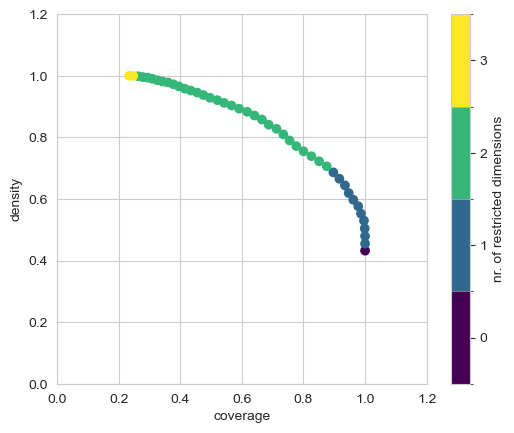

44 stappen in deze box


In [152]:
# A) De “beste” box volgens je threshold
box = prim_alg.find_box()
box.inspect()
box.show_tradeoff()
plt.show()# geeft een PrimBox terug
traj = box.peeling_trajectory
print(len(traj), "stappen in deze box")

[<Figure size 640x480 with 1 Axes>]

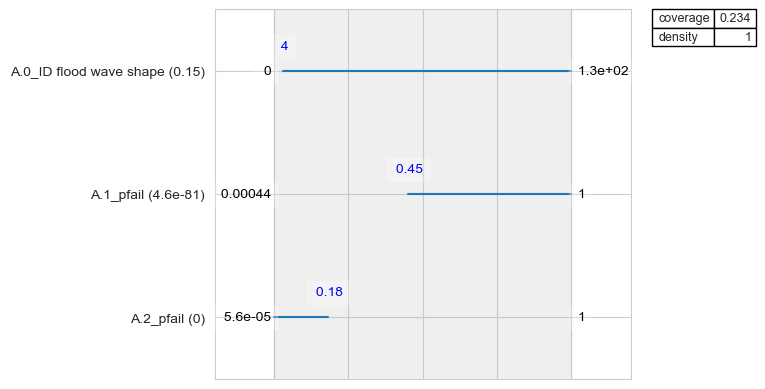

In [153]:
# en inspecteer 'm meteen
box.inspect( style="graph" )

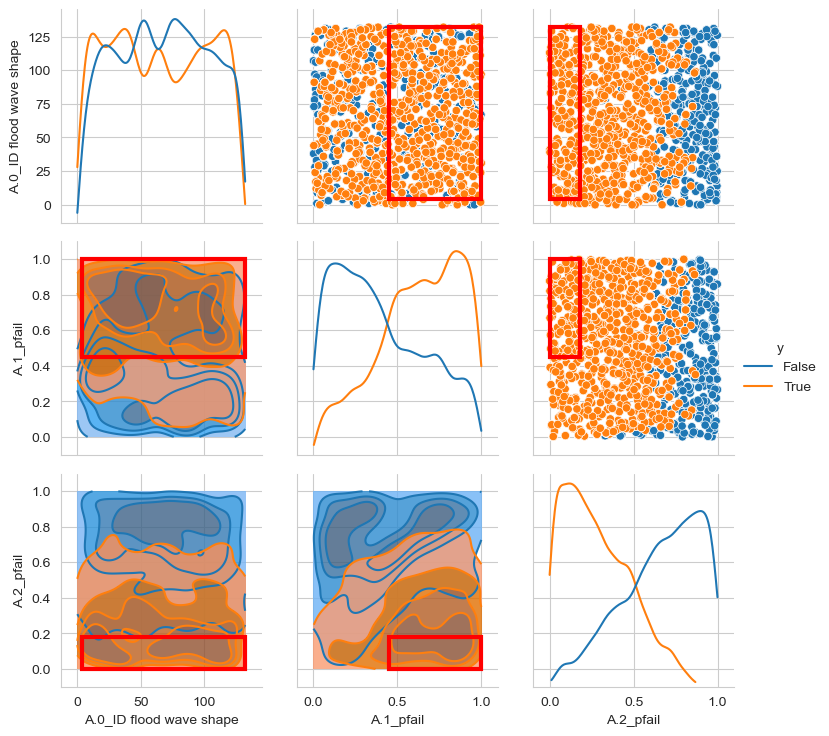

In [154]:
fig = box.show_pairs_scatter()
plt.show()

INFO | model dropped from analysis because only a single category


origineel aantal kolommen: 53
zonder levers           : 22


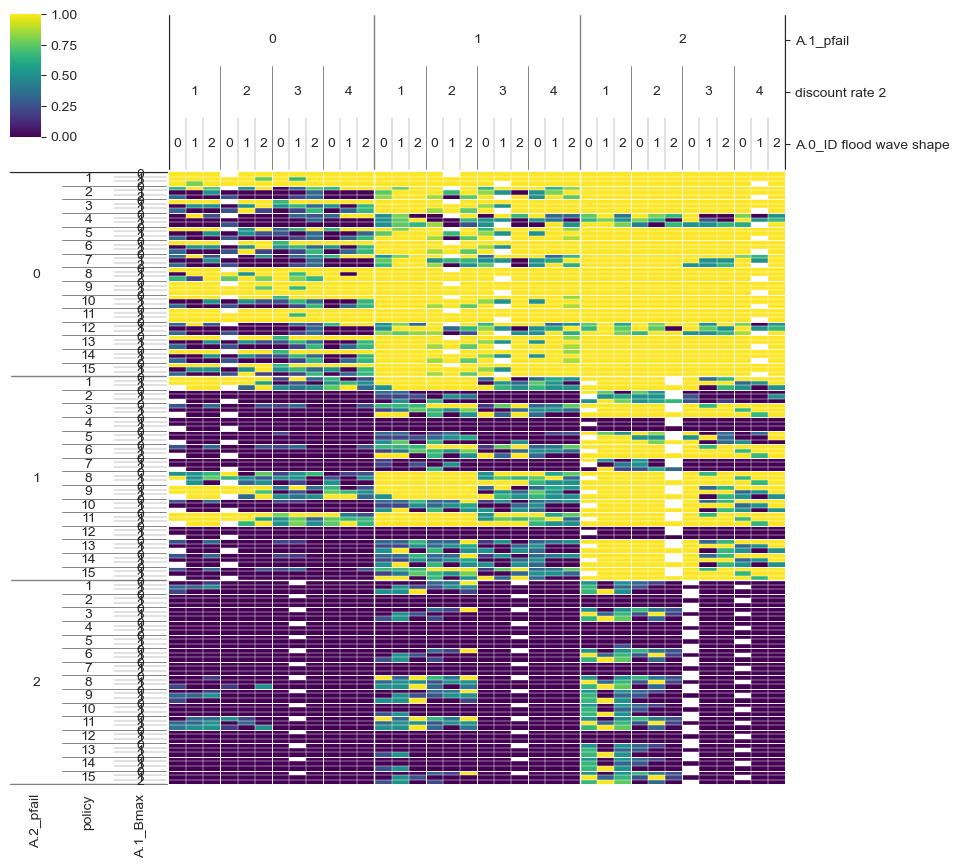

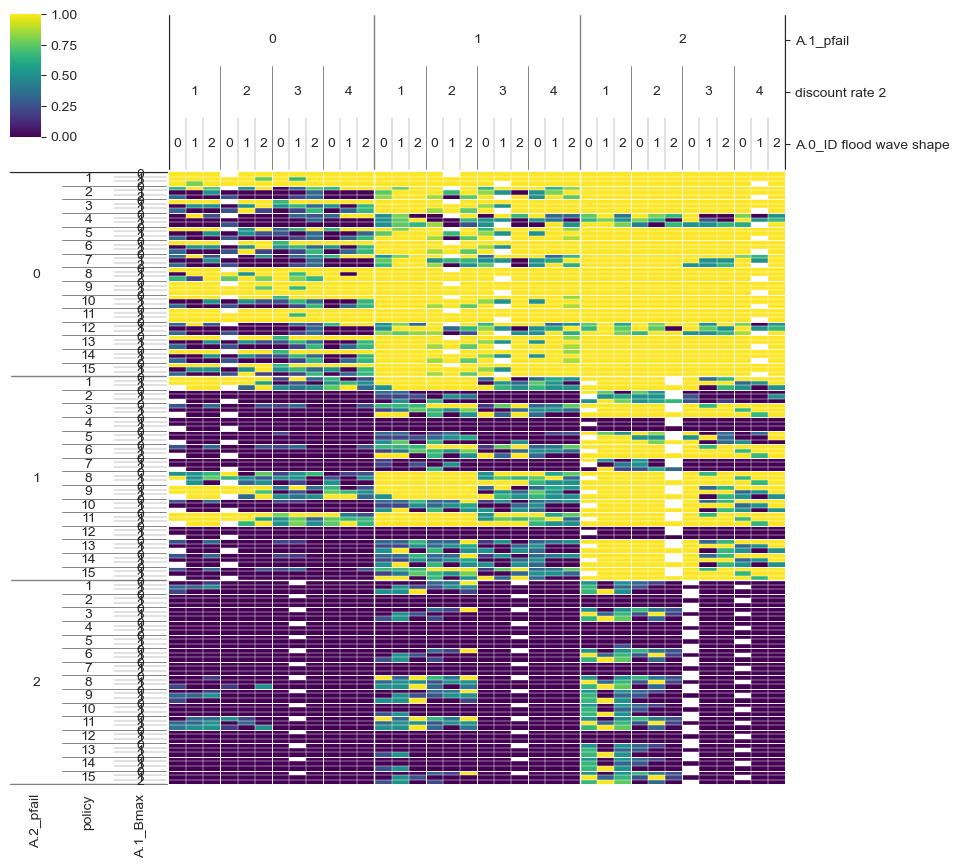

In [155]:
lever_names = [lev.name for lev in model.levers]
experiments_unc = experiments.drop(columns=lever_names)


# even checken:
print("origineel aantal kolommen:", experiments.shape[1])
print("zonder levers           :", experiments_unc.shape[1])

dimensional_stacking.create_pivot_plot(experiments_unc, y)


In [169]:
box.resample()

INFO | resample 0
INFO | resample 1
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
INFO | resample 2
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.5' has dtype 

,reproduce coverage,reproduce density
A.1_pfail,100.0,100.0
A.2_pfail,100.0,100.0
A.0_ID flood wave shape,60.0,60.0
A.5_pfail,60.0,60.0
A.5_Bmax,50.0,50.0
A.1_Bmax,30.0,40.0
A.3_Bmax,30.0,30.0
A.3_pfail,20.0,30.0
discount rate 2,10.0,20.0
A.2_Bmax,10.0,10.0


In [173]:
prim_alg.boxes_to_dataframe()


box 1          
                              min       max
A.2_pfail                0.000056  0.181075
A.1_pfail                0.449847  0.999777
A.0_ID flood wave shape         4       132

In [181]:
prim_alg.stats_to_dataframe()



,coverage,density,mass,res_dim
box 1,0.23376,1.0,0.101,3


In [121]:

# 1) Haal de grenzen op uit de box (list met één entry per box in je peeling_trajectory)
raw_limits = box.box_lims[0]

# 1) Transponeren, zodat elke var een rij wordt, en de kolommen 0 en 1 zijn
df_lim = raw_limits.T

# 2) Hernoemen van de kolommen 0→min en 1→max
df_lim = df_lim.rename(columns={0: "min", 1: "max"})

# 3) (optioneel) zet de index-naam netjes
df_lim.index.name = "var"


In [122]:
df_lim

,min,max
var,,
discount rate 0,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
discount rate 1,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
discount rate 2,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
A.0_ID flood wave shape,0,132
A.1_Bmax,30.272055,349.903416
A.1_pfail,0.000441,0.999777
A.1_Brate,"{1.0, 10.0, 1.5}","{1.0, 10.0, 1.5}"
A.2_Bmax,30.259878,349.73533
A.2_pfail,0.000056,0.999683


In [131]:
mask = pd.Series(True, index=experiments.index)

for var, row in df_lim.iterrows():
    lo, hi = row["min"], row["max"]
    ser = experiments[var]

    if is_numeric_dtype(ser):
        # voor numerieke parameters
        mask &= ser.between(lo, hi)
    else:
        # voor categorische parameters
        # lo kan een set/list zijn, of een enkele waarde
        if isinstance(lo, (set, list)):
            mask &= ser.isin(lo)
        else:
            mask &= (ser == lo)


exp_in_box = experiments[mask]
out_in_box = {
    name: array[mask.values]     # .values is een numpy‐boolean array
    for name, array in outcomes.items()
}

In [141]:
df_lim

,min,max
var,,
discount rate 0,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
discount rate 1,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
discount rate 2,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
A.0_ID flood wave shape,0,132
A.1_Bmax,30.272055,349.903416
A.1_pfail,0.000441,0.999777
A.1_Brate,"{1.0, 10.0, 1.5}","{1.0, 10.0, 1.5}"
A.2_Bmax,30.259878,349.73533
A.2_pfail,0.000056,0.999683


In [142]:
exp_in_box

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,49,69.981117,1.0,0.792412,285.593460,1.5,0.600928,309.788348,10.0,0.907098,...,2,4,1,5,7,3,5,1108,cand_0,dikesnet
1,114,159.028359,1.5,0.250807,128.200856,1.5,0.366086,305.734328,10.0,0.257366,...,2,4,1,5,7,3,5,1109,cand_0,dikesnet
2,132,303.533216,1.0,0.385127,214.601101,1.5,0.718454,92.619360,1.0,0.329028,...,2,4,1,5,7,3,5,1110,cand_0,dikesnet
3,100,285.385971,1.5,0.827791,240.665452,1.5,0.555214,281.844390,1.0,0.473930,...,2,4,1,5,7,3,5,1111,cand_0,dikesnet
4,66,187.605715,10.0,0.511556,149.588956,1.5,0.293560,195.302762,1.0,0.283548,...,2,4,1,5,7,3,5,1112,cand_0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,123,154.732165,10.0,0.157420,328.817569,1.0,0.162745,157.027096,1.0,0.926010,...,1,2,6,6,7,2,7,2103,cand_14,dikesnet
14996,48,294.560774,1.5,0.056532,108.257151,1.0,0.662680,251.805905,1.5,0.737270,...,1,2,6,6,7,2,7,2104,cand_14,dikesnet
14997,32,52.656177,10.0,0.393822,347.360799,1.5,0.920625,68.709771,1.5,0.788071,...,1,2,6,6,7,2,7,2105,cand_14,dikesnet
14998,96,176.697128,1.0,0.689853,154.476219,1.0,0.397939,114.116993,1.0,0.693305,...,1,2,6,6,7,2,7,2106,cand_14,dikesnet


In [143]:
out_in_box

{'A.1_Expected Annual Damage': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.05659353e+09, 5.32087984e+08, 0.00000000e+00],
        [4.42511393e+08, 4.42511393e+08, 0.00000000e+00],
        ...,
        [3.65896433e+08, 3.65896433e+08, 2.91495919e+08],
        [2.74125658e+07, 1.38046433e+07, 1.38046433e+07],
        [8.11860250e+08, 8.11860250e+08, 1.05297907e+09]]),
 'A.1_Dike Investment Costs': array([[       0.        ,        0.        , 53972506.18695759],
        [       0.        ,        0.        , 53972506.18695759],
        [       0.        ,        0.        , 53972506.18695759],
        ...,
        [       0.        ,        0.        ,        0.        ],
        [       0.        ,        0.        ,        0.        ],
        [       0.        ,        0.        ,        0.        ]]),
 'A.1_Expected Number of Deaths': array([[0.        , 0.        , 0.        ],
        [0.07831798, 0.07831798, 0.        ],
        [0.04332438, 0.04332438, 0. 

In [144]:

expanded = {}
for name, arr in out_in_box.items():
    if arr.ndim == 1:
        # gewoon een vector
        expanded[name] = arr
    else:
        # maak per tijdstap een kolom
        T = arr.shape[1]
        for t in range(T):
            expanded[f"{name}_{t}"] = arr[:, t]

out_df = pd.DataFrame(expanded)

In [145]:
out_df

,A.1_Expected Annual Damage_0,A.1_Expected Annual Damage_1,A.1_Expected Annual Damage_2,A.1_Dike Investment Costs_0,A.1_Dike Investment Costs_1,A.1_Dike Investment Costs_2,A.1_Expected Number of Deaths_0,A.1_Expected Number of Deaths_1,A.1_Expected Number of Deaths_2,A.1_Hydrological Resilience Index_0,...,A.5_Expected Number of Deaths_2,A.5_Hydrological Resilience Index_0,A.5_Hydrological Resilience Index_1,A.5_Hydrological Resilience Index_2,RfR Total Costs_0,RfR Total Costs_1,RfR Total Costs_2,Expected Evacuation Costs_0,Expected Evacuation Costs_1,Expected Evacuation Costs_2
0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,5.397251e+07,0.000000,0.000000,0.000000,0.4,...,0.0,0.33,0.37,0.35,30700000.0,0.0,0.0,513.022375,513.022375,513.022375
1,1.056594e+09,5.320880e+08,0.000000e+00,0.0,0.0,5.397251e+07,0.078318,0.078318,0.000000,0.4,...,0.0,0.33,0.37,0.35,30700000.0,0.0,0.0,6986.640766,6986.640766,1524.832309
2,4.425114e+08,4.425114e+08,0.000000e+00,0.0,0.0,5.397251e+07,0.043324,0.043324,0.000000,0.4,...,0.0,0.33,0.37,0.35,30700000.0,0.0,0.0,3726.732260,3726.732260,329.026224
3,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,5.397251e+07,0.000000,0.000000,0.000000,0.4,...,0.0,0.33,0.37,0.35,30700000.0,0.0,0.0,515.670995,515.670995,515.670995
4,4.730776e+07,3.878574e+07,0.000000e+00,0.0,0.0,5.397251e+07,0.006069,0.006069,0.000000,0.4,...,0.0,0.33,0.37,0.35,30700000.0,0.0,0.0,6417.060371,2125.696828,1504.499252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1.069133e+09,1.069133e+09,5.384025e+08,0.0,0.0,0.000000e+00,0.529861,0.529861,0.529861,-1.0,...,0.0,-0.07,-0.02,-0.07,0.0,0.0,0.0,0.000000,0.000000,0.000000
14996,7.994127e+08,6.368620e+08,7.994127e+08,0.0,0.0,0.000000e+00,0.509926,0.509926,0.509926,-1.0,...,0.0,-0.07,-0.02,-0.07,0.0,0.0,0.0,0.000000,0.000000,0.000000
14997,3.658964e+08,3.658964e+08,2.914959e+08,0.0,0.0,0.000000e+00,0.240289,0.240289,0.240289,-1.0,...,0.0,-0.07,-0.02,-0.07,0.0,0.0,0.0,0.000000,0.000000,0.000000
14998,2.741257e+07,1.380464e+07,1.380464e+07,0.0,0.0,0.000000e+00,0.014842,0.014842,0.014842,-1.0,...,0.0,-0.07,-0.02,-0.07,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [182]:
# bereken EAD per run in de box
ead = out_in_box["A.2_Expected Annual Damage"].sum(axis=1)

# voeg toe aan je exp_in_box
exp_in_box = exp_in_box.assign(EAD=ead)

# 1) Worst-case = run met hoogste EAD
worst_case = exp_in_box.nlargest(1, "EAD")

# 2) Best-case  = run met laagste EAD
best_case  = exp_in_box.nsmallest(1, "EAD")

# 3) Median-case = run die in het midden zit van je box-subset
median_idx = int(len(exp_in_box) // 2)
median_case = exp_in_box.iloc[[median_idx]]

print("BEST-case:\n", best_case)
print("MEDIAN:\n", median_case)
print("WORST-case:\n", worst_case)

BEST-case:
     A.0_ID flood wave shape   A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
31                       14  320.90093       1.5   0.033959  140.425093   

   A.2_Brate  A.2_pfail   A.3_Bmax A.3_Brate  A.3_pfail  ...  \
31       1.5   0.610206  90.183922       1.5   0.942077  ...   

    A.4_DikeIncrease 0 A.4_DikeIncrease 1  A.4_DikeIncrease 2  \
31                   4                  1                   5   

    A.5_DikeIncrease 0 A.5_DikeIncrease 1  A.5_DikeIncrease 2 scenario  \
31                   7                  3                   5     1139   

    policy     model  EAD  
31  cand_0  dikesnet  0.0  

[1 rows x 54 columns]
MEDIAN:
       A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
7500                       36  100.613332      10.0   0.335626  199.149715   

     A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
7500      10.0   0.762775  328.502791       1.0   0.838116  ...   

      A.4_DikeIncrease 0 A.4_DikeIncrease 1  A.4

In [183]:
best_case

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,EAD
31,14,320.90093,1.5,0.033959,140.425093,1.5,0.610206,90.183922,1.5,0.942077,...,4,1,5,7,3,5,1139,cand_0,dikesnet,0.0


In [184]:
median_case

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,EAD
7500,36,100.613332,10.0,0.335626,199.149715,10.0,0.762775,328.502791,1.0,0.838116,...,9,5,3,9,2,5,1608,cand_7,dikesnet,0.0


In [185]:
worst_case

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,EAD
2930,67,98.267897,10.0,0.749968,230.389994,1.0,0.020571,200.050942,1.0,0.210249,...,6,2,7,6,1,4,2038,cand_2,dikesnet,1.098426e+09


In [188]:
# --- 1) normaliseer EAD en HRI naar [0,1] ---
# (we nemen min-max normalisatie binnen de box)
ead = exp_in_box["EAD"].values
hri = exp_in_box["HRI"].values

ead_min, ead_max = ead.min(), ead.max()
hri_min, hri_max = hri.min(), hri.max()

ead_norm = (ead - ead_min) / (ead_max - ead_min)
hri_norm = (hri - hri_min) / (hri_max - hri_min)

# --- 2) bereken gecombineerde score voor slecht/goed ---
# hoe hoger de score, hoe “slechter” (hoog EAD én laag HRI)
score = ead_norm + (1 - hri_norm)

exp_in_box["score"] = score

# --- 3) kies je drie cases ---
worst_case  = exp_in_box.nlargest(1, "score")
best_case   = exp_in_box.nsmallest(1, "score")
median_case = exp_in_box.iloc[[len(exp_in_box)//2]]

print("── Combined‐cases ───────────────────────────────────────")
print("WORST‐case (hoogste score):\n", worst_case)
print("\nMEDIAN‐case (middelste index):\n", median_case)
print("\nBEST‐case (laagste score):\n", best_case)

── Combined‐cases ───────────────────────────────────────
WORST‐case (hoogste score):
        A.0_ID flood wave shape   A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
14930                       67  98.267897      10.0   0.749968  230.389994   

      A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
14930       1.0   0.020571  200.050942       1.0   0.210249  ...   

       A.4_DikeIncrease 2 A.5_DikeIncrease 0  A.5_DikeIncrease 1  \
14930                   6                  7                   2   

       A.5_DikeIncrease 2 scenario   policy     model           EAD       HRI  \
14930                   7     2038  cand_14  dikesnet  1.098399e+09 -1.006667   

          score  
14930  1.999976  

[1 rows x 56 columns]

MEDIAN‐case (middelste index):
       A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
7500                       36  100.613332      10.0   0.335626  199.149715   

     A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
750

In [189]:
worst_case

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,EAD,HRI,score
14930,67,98.267897,10.0,0.749968,230.389994,1.0,0.020571,200.050942,1.0,0.210249,...,6,7,2,7,2038,cand_14,dikesnet,1.098399e+09,-1.006667,1.999976


In [190]:
median_case

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,EAD,HRI,score
7500,36,100.613332,10.0,0.335626,199.149715,10.0,0.762775,328.502791,1.0,0.838116,...,3,9,2,5,1608,cand_7,dikesnet,0.0,0.4,0.316045


In [191]:
best_case

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,EAD,HRI,score
11001,114,159.028359,1.5,0.250807,128.200856,1.5,0.366086,305.734328,10.0,0.257366,...,10,7,3,4,1109,cand_11,dikesnet,0.0,1.05,0.0


In [195]:
# 1) voeg y als kolom toe
exp_in_box = exp_in_box.copy()
exp_in_box['worst_case'] = y[exp_in_box.index]

# 2) houd alleen echte worst-cases over
true_worst = exp_in_box[exp_in_box['worst_case']]

# 3) kies uit true_worst je max/min/median voor EAD & HRI
best  = true_worst.nsmallest(1, 'score')   #worst case is hoogste score
worst = true_worst.nlargest(1,  'score')          #best case is kleinste score
mid   = true_worst.iloc[[len(true_worst)//2]]

In [194]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,EAD,HRI,score,worst_case
0,49,69.981117,1.0,0.792412,285.593460,1.5,0.600928,309.788348,10.0,0.907098,...,7,3,5,1108,cand_0,dikesnet,4.695928e+07,-0.600000,0.845020,True
1,114,159.028359,1.5,0.250807,128.200856,1.5,0.366086,305.734328,10.0,0.257366,...,7,3,5,1109,cand_0,dikesnet,4.612815e+07,-0.600000,0.844264,True
2,132,303.533216,1.0,0.385127,214.601101,1.5,0.718454,92.619360,1.0,0.329028,...,7,3,5,1110,cand_0,dikesnet,1.009510e+07,-0.600000,0.811460,True
3,100,285.385971,1.5,0.827791,240.665452,1.5,0.555214,281.844390,1.0,0.473930,...,7,3,5,1111,cand_0,dikesnet,3.947529e+07,-0.600000,0.838207,True
4,66,187.605715,10.0,0.511556,149.588956,1.5,0.293560,195.302762,1.0,0.283548,...,7,3,5,1112,cand_0,dikesnet,7.304500e+07,-0.600000,0.868769,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,105,247.326412,10.0,0.824903,242.221243,10.0,0.055439,115.539341,1.0,0.290392,...,7,2,7,2083,cand_14,dikesnet,5.778200e+08,-1.006667,1.526044,True
14978,5,118.966711,10.0,0.861624,308.912144,1.0,0.296039,44.635752,1.5,0.330505,...,7,2,7,2086,cand_14,dikesnet,3.798365e+07,-1.006667,1.034580,True
14982,102,43.803950,1.0,0.937615,158.063574,1.0,0.198149,167.859585,10.0,0.239683,...,7,2,7,2090,cand_14,dikesnet,6.271161e+07,-1.006667,1.057092,True
14984,14,206.301768,10.0,0.881911,142.532460,10.0,0.169573,155.125786,1.5,0.986333,...,7,2,7,2092,cand_14,dikesnet,1.305261e+08,-1.006667,1.118830,True


In [196]:
best

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,EAD,HRI,score,worst_case
11149,3,240.59686,10.0,0.800122,162.388872,10.0,0.248191,97.503836,1.5,0.472066,...,7,3,4,1257,cand_11,dikesnet,1.049853e+08,0.05,0.581802,True


In [197]:
worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,EAD,HRI,score,worst_case
14930,67,98.267897,10.0,0.749968,230.389994,1.0,0.020571,200.050942,1.0,0.210249,...,7,2,7,2038,cand_14,dikesnet,1.098399e+09,-1.006667,1.999976,True


In [198]:
mid

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,EAD,HRI,score,worst_case
5993,60,148.203377,10.0,0.946282,330.511958,10.0,0.481342,321.353772,1.0,0.104562,...,7,5,5,2101,cand_5,dikesnet,9.980354e+07,-1.0,1.087619,True


In [203]:
# 1) knijp de rij samen naar een Series
best_s   = best.iloc[0]  # of .iloc[0]
mid_s = median_case.iloc[0]
worst_s  = worst_case.iloc[0]



df_scenarios = pd.DataFrame([
    best_s.to_dict(),
    mid_s.to_dict(),
    worst_s.to_dict()
], index=["best_case", "median_case", "worst_case"])

In [204]:
df_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,EAD,HRI,score,worst_case
best_case,3,240.596860,10.0,0.800122,162.388872,10.0,0.248191,97.503836,1.5,0.472066,...,7,3,4,1257,cand_11,dikesnet,1.049853e+08,0.050000,0.581802,True
median_case,36,100.613332,10.0,0.335626,199.149715,10.0,0.762775,328.502791,1.0,0.838116,...,9,2,5,1608,cand_7,dikesnet,0.000000e+00,0.400000,0.316045,NaN
worst_case,67,98.267897,10.0,0.749968,230.389994,1.0,0.020571,200.050942,1.0,0.210249,...,7,2,7,2038,cand_14,dikesnet,1.098399e+09,-1.006667,1.999976,NaN


In [205]:
df_scenarios.to_csv("reference_scenarios.csv", index_label="scenario")
